# Background

The goal of reducing sequential computation also forms the foundation of the Extended Neural GPU, ByteNet and ConvS2S, all of which use convolutional neural networks as basic building block, computing hidden representations in parallel for all input and output positions. In these models, the number of operations required to relate signals from two arbitrary input or output positions grows in the distance between positions, linearly for ConvS2S and logarithmically for ByteNet. This makes it more difficult to learn dependencies between distant positions. In the Transformer this is reduced to a constant number of operations, albeit at the cost of reduced effective resolution due to averaging attention-weighted positions, an effect we counteract with Multi-Head Attention.

Self-attention, sometimes called intra-attention is an attention mechanism relating different positions of a single sequence in order to compute a representation of the sequence. Self-attention has been used successfully in a variety of tasks including reading comprehension, abstractive summarization, textual entailment and learning task-independent sentence representations. End-to-end memory networks are based on a recurrent attention mechanism instead of sequencealigned recurrence and have been shown to perform well on simple-language question answering and
language modeling tasks.

To the best of our knowledge, however, the Transformer is the first transduction model relying entirely on self-attention to compute representations of its input and output without using sequence aligned RNNs or convolution.

![alt text](https://raw.githubusercontent.com/harvardnlp/annotated-transformer/master/images/aiayn.png)

The Transformer from ["Attention is All You Need"](https://arxiv.org/abs/1706.03762) has been on a lot of people's minds over the last year. Besides producing major improvements in translation quality, it provides a new architecture for many other NLP tasks. The paper itself is very clearly written, but the conventional wisdom has been that it is quite difficult to implement correctly.

In this notebook we present an "annotated" version of the paper in the form of a line-by-line implementation. I have reordered and deleted some sections from the original paper and added comments throughout. This document itself is a working notebook, and should be a completely usable implementation. In total there are 400 lines of library code which can process 27,000 tokens per second on 4 GPUs.

To follow along you will first need to install [PyTorch](http://pytorch.org/). The complete notebook is also available on [github](https://github.com/harvardnlp/annotated-transformer) or on Google [Colab](https://drive.google.com/file/d/1xQXSv6mtAOLXxEMi8RvaW8TW-7bvYBDF/view?usp=sharing).

Note this is merely a starting point for researchers and interested developers. The code here is based heavily on our [OpenNMT](http://opennmt.net) packages. (If helpful feel free to [cite](#conclusion).) For other full-sevice implementations of the model check-out [Tensor2Tensor](https://github.com/tensorflow/tensor2tensor) (tensorflow) and [Sockeye](https://github.com/awslabs/sockeye) (mxnet).

- Alexander Rush ([@harvardnlp](https://twitter.com/harvardnlp) or srush@seas.harvard.edu)




---



We, [SkoltechNLP](https://sites.skoltech.ru/nlp/) group, [revisited this notebook in April 2021](https://github.com/skoltech-nlp/annotated-transformer) and made some adjusments to make it runnable like "Run All Cells" with updated required packages. Aslo, we add some clarifing images from the amazing resources about Transformers that emerged during these years:
* [Seq2Seq and Attention by Lena Voita](https://lena-voita.github.io/nlp_course/seq2seq_and_attention.html)
* [The Illustrated Transformer](https://jalammar.github.io/illustrated-transformer/)

We believe that will add some additional understanding of the main idea and code. Enjoy your Transformer!

*   Daryna Dementieva ([@dementyeva_ds](https:///dementyeva_ds) in any social network or daryna.dementieva@skoltech.ru)
*   Anton Razzhigaev (anton.razzhigaev@skoltech.ru)
*   Alexander Panchenko (a.panchenko@skoltech.ru)


# Prelims

In [ ]:
# !pip install http://download.pytorch.org/whl/cu80/torch-0.3.0.post4-cp36-cp36m-linux_x86_64.whl numpy matplotlib spacy torchtext seaborn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
ERROR: torch-0.3.0.post4-cp36-cp36m-linux_x86_64.whl is not a supported wheel on this platform.


In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import math, copy, time
from torch.autograd import Variable
import matplotlib.pyplot as plt
import seaborn
seaborn.set_context(context="talk")
%matplotlib inline

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

> My comments are blockquoted. The main text is all from the paper itself.

# Model Architecture

![alt text](https://raw.githubusercontent.com/harvardnlp/annotated-transformer/master/images/ModalNet-21.png)

Most competitive neural sequence transduction models have an encoder-decoder structure [(cite)](https://arxiv.org/abs/1409.0473). Here, the encoder maps an input sequence of symbol representations $(x_1, ..., x_n)$ to a sequence of continuous representations $\mathbf{z} = (z_1, ..., z_n)$. Given $\mathbf{z}$, the decoder then generates an output sequence $(y_1,...,y_m)$ of symbols one element at a time. At each step the model is auto-regressive [(cite)](https://arxiv.org/abs/1308.0850), consuming the previously generated symbols as additional input when generating the next.

![alt text](https://lena-voita.github.io/resources/lectures/seq2seq/transformer/encdec_intuitive_words-min.png)
Source: [Lena Voita's Lecture about Seq2Seq](https://lena-voita.github.io/nlp_course/seq2seq_and_attention.html)

In [ ]:
class EncoderDecoder(nn.Module):
    """
    A standard Encoder-Decoder architecture. Base for this and many
    other models.
    """
    def __init__(self, encoder, decoder, src_embed, tgt_embed, generator):
        super(EncoderDecoder, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.src_embed = src_embed
        self.tgt_embed = tgt_embed
        self.generator = generator

    def forward(self, src, tgt, src_mask, tgt_mask):
        "Take in and process masked src and target sequences."
        return self.decode(self.encode(src, src_mask), src_mask,
                            tgt, tgt_mask)

    def encode(self, src, src_mask):
        return self.encoder(self.src_embed(src), src_mask)

    def decode(self, memory, src_mask, tgt, tgt_mask):
        return self.decoder(self.tgt_embed(tgt), memory, src_mask, tgt_mask)

In [ ]:
class Generator(nn.Module):
    "Define standard linear + softmax generation step."
    def __init__(self, d_model, vocab):
        super(Generator, self).__init__()
        self.proj = nn.Linear(d_model, vocab)

    def forward(self, x):
        return F.log_softmax(self.proj(x), dim=-1)

The Transformer follows this overall architecture using stacked self-attention and point-wise, fully connected layers for both the encoder and decoder, shown in the left and right halves of Figure 1, respectively.

## Encoder and Decoder Stacks

### Encoder

The encoder is composed of a stack of $N=6$ identical layers.

In [ ]:
def clones(module, N):
    "Produce N identical layers."
    return nn.ModuleList([copy.deepcopy(module) for _ in range(N)])

In [ ]:
class Encoder(nn.Module):
    "Core encoder is a stack of N layers"
    def __init__(self, layer, N):
        super(Encoder, self).__init__()
        self.layers = clones(layer, N)
        self.norm = LayerNorm(layer.size)

    def forward(self, x, mask):
        "Pass the input (and mask) through each layer in turn."
        for layer in self.layers:
            x = layer(x, mask)
        return self.norm(x)

We employ a residual connection [(cite)](https://arxiv.org/abs/1512.03385) around each of the two sub-layers, followed by layer normalization [(cite)](https://arxiv.org/abs/1607.06450).

In [ ]:
class LayerNorm(nn.Module):
    "Construct a layernorm module (See citation for details)."
    def __init__(self, features, eps=1e-6):
        super(LayerNorm, self).__init__()
        self.a_2 = nn.Parameter(torch.ones(features))
        self.b_2 = nn.Parameter(torch.zeros(features))
        self.eps = eps

    def forward(self, x):
        """ Return a2 * x_normalized + b2,
        where x_normalized is calculated by subtracting row-wise means from x and dividing the result by row-wise standard deviation + eps.
        standard deviation is calculated with Bessel's correction (the default in Pytorch)
        """
        # todo: implement this method
        mean = x.mean(-1, keepdim=True)
        std = x.std(-1, keepdim=True)
        return self.a_2 * (x - mean) / (std + self.eps) + self.b_2

> **You have to implement the `forward` method of LayerNorm above. The cell below tests your implementation.**

In [ ]:
ln = LayerNorm(2, eps=0)
with torch.no_grad():
    result = ln(torch.tensor([[0.0, 1], [100, 101], [100, 200]])).numpy()

# becasue of Bessel's correction, standard deviation is pulled to 0. Here we un-pull it back.
print(result)
result_unnormalized = result / np.sqrt(0.5)
assert (result_unnormalized[:, 0] == -1).all()
assert (result_unnormalized[:, 1] == 1).all()

[[-0.70710677  0.70710677]
 [-0.70710677  0.70710677]
 [-0.70710677  0.70710677]]


That is, the output of each sub-layer is $\mathrm{LayerNorm}(x + \mathrm{Sublayer}(x))$, where $\mathrm{Sublayer}(x)$ is the function implemented by the sub-layer itself.  We apply dropout [(cite)](http://jmlr.org/papers/v15/srivastava14a.html) to the output of each sub-layer, before it is added to the sub-layer input and normalized.

To facilitate these residual connections, all sub-layers in the model, as well as the embedding layers, produce outputs of dimension $d_{\text{model}}=512$.

In [ ]:
class SublayerConnection(nn.Module):
    """
    A residual connection followed by a layer norm.
    Note for code simplicity the norm is first as opposed to last.
    """
    def __init__(self, size, dropout):
        super(SublayerConnection, self).__init__()
        self.norm = LayerNorm(size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, sublayer):
        "Apply residual connection to any sublayer with the same size."
        return x + self.dropout(sublayer(self.norm(x)))

Each layer has two sub-layers. The first is a multi-head self-attention mechanism, and the second is a simple, position-wise fully connected feed-forward network.

In [ ]:
class EncoderLayer(nn.Module):
    "Encoder is made up of self-attn and feed forward (defined below)"
    def __init__(self, size, self_attn, feed_forward, dropout):
        super(EncoderLayer, self).__init__()
        self.self_attn = self_attn
        self.feed_forward = feed_forward
        self.sublayer = clones(SublayerConnection(size, dropout), 2)
        self.size = size

    def forward(self, x, mask):
        "Follow Figure 1 (left) for connections."
        x = self.sublayer[0](x, lambda x: self.self_attn(x, x, x, mask))
        return self.sublayer[1](x, self.feed_forward)

### Decoder

The decoder is also composed of a stack of $N=6$ identical layers.


In [ ]:
class Decoder(nn.Module):
    "Generic N layer decoder with masking."
    def __init__(self, layer, N):
        super(Decoder, self).__init__()
        self.layers = clones(layer, N)
        self.norm = LayerNorm(layer.size)

    def forward(self, x, memory, src_mask, tgt_mask):
        for layer in self.layers:
            x = layer(x, memory, src_mask, tgt_mask)
        return self.norm(x)

In addition to the two sub-layers in each encoder layer, the decoder inserts a third sub-layer, which performs multi-head attention over the output of the encoder stack.  Similar to the encoder, we employ residual connections around each of the sub-layers, followed by layer normalization.

In [ ]:
class DecoderLayer(nn.Module):
    "Decoder is made of self-attn, src-attn, and feed forward (defined below)"
    def __init__(self, size, self_attn, src_attn, feed_forward, dropout):
        super(DecoderLayer, self).__init__()
        self.size = size
        self.self_attn = self_attn
        self.src_attn = src_attn
        self.feed_forward = feed_forward
        self.sublayer = clones(SublayerConnection(size, dropout), 3)

    def forward(self, x, memory, src_mask, tgt_mask):
        "Follow Figure 1 (right) for connections."
        m = memory
        x = self.sublayer[0](x, lambda x: self.self_attn(x, x, x, tgt_mask))
        x = self.sublayer[1](x, lambda x: self.src_attn(x, m, m, src_mask))
        return self.sublayer[2](x, self.feed_forward)

We also modify the self-attention sub-layer in the decoder stack to prevent positions from attending to subsequent positions.  This masking, combined with fact that the output embeddings are offset by one position, ensures that the predictions for position $i$ can depend only on the known outputs at positions less than $i$.

In [ ]:
def subsequent_mask(size):
    "Mask out subsequent positions."
    attn_shape = (1, size, size)
    subsequent_mask = np.triu(np.ones(attn_shape), k=1).astype('uint8')
    return torch.from_numpy(subsequent_mask) == 0

> Below the attention mask shows the position each tgt word (row) is allowed to look at (column). Words are blocked for attending to future words during training.

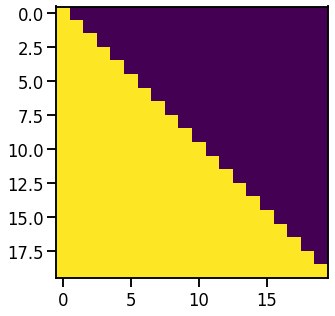

In [ ]:
plt.figure(figsize=(5,5))
plt.imshow(subsequent_mask(20)[0])
None

### Attention
An attention function can be described as mapping a query and a set of key-value pairs to an output, where the query, keys, values, and output are all vectors.  The output is computed as a weighted sum of the values, where the weight assigned to each value is computed by a compatibility function of the query with the corresponding key.

We call our particular attention "Scaled Dot-Product Attention".   The input consists of queries and keys of dimension $d_k$, and values of dimension $d_v$.  We compute the dot products of the query with all keys, divide each by $\sqrt{d_k}$, and apply a softmax function to obtain the weights on the values.


![alt text](https://raw.githubusercontent.com/harvardnlp/annotated-transformer/master/images/ModalNet-19.png)


In practice, we compute the attention function on a set of queries simultaneously, packed together into a matrix $Q$.   The keys and values are also packed together into matrices $K$ and $V$.  We compute the matrix of outputs as:

$$
   \mathrm{Attention}(Q, K, V) = \mathrm{softmax}(\frac{QK^T}{\sqrt{d_k}})V
$$

![alt text](https://lena-voita.github.io/resources/lectures/seq2seq/transformer/qkv_explained-min.png)
Source: [Lena Voita's Lecture about Seq2Seq](https://lena-voita.github.io/nlp_course/seq2seq_and_attention.html)

In [ ]:
def attention(query, key, value, mask=None, dropout=None):
    """Compute 'Scaled Dot Product Attention'
    """
    d_k = query.size(-1)
    # todo: compute the attention scores by using torch.matmul
    scores = torch.matmul(query, key.transpose(-2, -1)) / math.sqrt(d_k)
    if mask is not None:
        scores = scores.masked_fill(mask == 0, -1e9)
    p_attn = F.softmax(scores, dim = -1)
    if dropout is not None:
        p_attn = dropout(p_attn)
    # todo: compute the result as the values weighted by attention probabilities (again, using torch.matmul)
    result = torch.matmul(p_attn, value)
    return result, p_attn

> **You have to complete the `attention` function above. The cell below tests your implementation.**

In [ ]:
results, attentions = attention(
    torch.tensor([[0, 0], [0, 1], [1, 1]], dtype=torch.float),
    torch.tensor([[100, 0], [0, 100], [0, 0]], dtype=torch.float),
    torch.tensor([[1, 0], [0, 1], [0, 0]], dtype=torch.float),
)
print(results)
print(attentions)

assert np.allclose(results[0].numpy(), [1/3, 1/3])  # the first query attends to all keys equally
assert np.allclose(results[1].numpy(), [0, 1])      # the second query attends only to the second key
assert np.allclose(results[2].numpy(), [1/2, 1/2])  # the third query attends to the first and second key equally

tensor([[3.3333e-01, 3.3333e-01],
        [1.9532e-31, 1.0000e+00],
        [5.0000e-01, 5.0000e-01]])
tensor([[3.3333e-01, 3.3333e-01, 3.3333e-01],
        [1.9532e-31, 1.0000e+00, 1.9532e-31],
        [5.0000e-01, 5.0000e-01, 9.7659e-32]])


The two most commonly used attention functions are additive attention [(cite)](https://arxiv.org/abs/1409.0473), and dot-product (multiplicative) attention.  Dot-product attention is identical to our algorithm, except for the scaling factor of $\frac{1}{\sqrt{d_k}}$. Additive attention computes the compatibility function using a feed-forward network with a single hidden layer.  While the two are similar in theoretical complexity, dot-product attention is much faster and more space-efficient in practice, since it can be implemented using highly optimized matrix multiplication code.


While for small values of $d_k$ the two mechanisms perform similarly, additive attention outperforms dot product attention without scaling for larger values of $d_k$ [(cite)](https://arxiv.org/abs/1703.03906). We suspect that for large values of $d_k$, the dot products grow large in magnitude, pushing the softmax function into regions where it has extremely small gradients  (To illustrate why the dot products get large, assume that the components of $q$ and $k$ are independent random variables with mean $0$ and variance $1$.  Then their dot product, $q \cdot k = \sum_{i=1}^{d_k} q_ik_i$, has mean $0$ and variance $d_k$.). To counteract this effect, we scale the dot products by $\frac{1}{\sqrt{d_k}}$.

![alt text](https://raw.githubusercontent.com/harvardnlp/annotated-transformer/master/images/ModalNet-20.png)

Multi-head attention allows the model to jointly attend to information from different representation subspaces at different positions. With a single attention head, averaging inhibits this.
$$
\mathrm{MultiHead}(Q, K, V) = \mathrm{Concat}(\mathrm{head_1}, ..., \mathrm{head_h})W^O    \\
    \text{where}~\mathrm{head_i} = \mathrm{Attention}(QW^Q_i, KW^K_i, VW^V_i)
$$

Where the projections are parameter matrices $W^Q_i \in \mathbb{R}^{d_{\text{model}} \times d_k}$, $W^K_i \in \mathbb{R}^{d_{\text{model}} \times d_k}$, $W^V_i \in \mathbb{R}^{d_{\text{model}} \times d_v}$ and $W^O \in \mathbb{R}^{hd_v \times d_{\text{model}}}$.                                                                                                                                                                                             In this work we employ $h=8$ parallel attention layers, or heads. For each of these we use $d_k=d_v=d_{\text{model}}/h=64$. Due to the reduced dimension of each head, the total computational cost is similar to that of single-head attention with full dimensionality.

![alt text](https://jalammar.github.io/images/t/transformer_multi-headed_self-attention-recap.png)
Source: [The Illustrated Transformer](https://jalammar.github.io/illustrated-transformer/)

In [ ]:
class MultiHeadedAttention(nn.Module):
    def __init__(self, h, d_model, dropout=0.1):
        "Take in model size and number of heads."
        super(MultiHeadedAttention, self).__init__()
        assert d_model % h == 0
        # We assume d_v always equals d_k
        self.d_k = d_model // h
        self.h = h
        self.linears = clones(nn.Linear(d_model, d_model), 4)
        self.attn = None
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, query, key, value, mask=None):
        "Implements Figure 2"
        if mask is not None:
            # Same mask applied to all h heads.
            mask = mask.unsqueeze(1)
        nbatches = query.size(0)

        # 1) Do all the linear projections in batch from d_model => h x d_k
        query, key, value = \
            [l(x).view(nbatches, -1, self.h, self.d_k).transpose(1, 2)
             for l, x in zip(self.linears, (query, key, value))]

        # 2) Apply attention on all the projected vectors in batch.
        x, self.attn = attention(query, key, value, mask=mask,
                                 dropout=self.dropout)

        # 3) "Concat" using a view and apply a final linear.
        x = x.transpose(1, 2).contiguous() \
             .view(nbatches, -1, self.h * self.d_k)
        return self.linears[-1](x)

### Applications of Attention in our Model
The Transformer uses multi-head attention in three different ways:
1) In "encoder-decoder attention" layers, the queries come from the previous decoder layer, and the memory keys and values come from the output of the encoder.   This allows every position in the decoder to attend over all positions in the input sequence.  This mimics the typical encoder-decoder attention mechanisms in sequence-to-sequence models such as [(cite)](https://arxiv.org/abs/1609.08144).


2) The encoder contains self-attention layers.  In a self-attention layer all of the keys, values and queries come from the same place, in this case, the output of the previous layer in the encoder.   Each position in the encoder can attend to all positions in the previous layer of the encoder.


3) Similarly, self-attention layers in the decoder allow each position in the decoder to attend to all positions in the decoder up to and including that position.  We need to prevent leftward information flow in the decoder to preserve the auto-regressive property.  We implement this inside of scaled dot-product attention by masking out (setting to $-\infty$) all values in the input of the softmax which correspond to illegal connections.

## Position-wise Feed-Forward Networks

In addition to attention sub-layers, each of the layers in our encoder and decoder contains a fully connected feed-forward network, which is applied to each position separately and identically.  This consists of two linear transformations with a ReLU activation in between.

$$\mathrm{FFN}(x)=\max(0, xW_1 + b_1) W_2 + b_2$$

While the linear transformations are the same across different positions, they use different parameters from layer to layer. Another way of describing this is as two convolutions with kernel size 1.  The dimensionality of input and output is $d_{\text{model}}=512$, and the inner-layer has dimensionality $d_{ff}=2048$.

In [ ]:
class PositionwiseFeedForward(nn.Module):
    "Implements FFN equation."
    def __init__(self, d_model, d_ff, dropout=0.1):
        super(PositionwiseFeedForward, self).__init__()
        self.w_1 = nn.Linear(d_model, d_ff)
        self.w_2 = nn.Linear(d_ff, d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        return self.w_2(self.dropout(F.relu(self.w_1(x))))

## Embeddings and Softmax
Similarly to other sequence transduction models, we use learned embeddings to convert the input tokens and output tokens to vectors of dimension $d_{\text{model}}$.  We also use the usual learned linear transformation and softmax function to convert the decoder output to predicted next-token probabilities.  In our model, we share the same weight matrix between the two embedding layers and the pre-softmax linear transformation, similar to [(cite)](https://arxiv.org/abs/1608.05859). In the embedding layers, we multiply those weights by $\sqrt{d_{\text{model}}}$.

In [ ]:
class Embeddings(nn.Module):
    def __init__(self, d_model, vocab):
        super(Embeddings, self).__init__()
        self.lut = nn.Embedding(vocab, d_model)
        self.d_model = d_model

    def forward(self, x):
        return self.lut(x) * math.sqrt(self.d_model)

## Positional Encoding
Since our model contains no recurrence and no convolution, in order for the model to make use of the order of the sequence, we must inject some information about the relative or absolute position of the tokens in the sequence.  To this end, we add "positional encodings" to the input embeddings at the bottoms of the encoder and decoder stacks.  The positional encodings have the same dimension $d_{\text{model}}$ as the embeddings, so that the two can be summed.   There are many choices of positional encodings, learned and fixed [(cite)](https://arxiv.org/pdf/1705.03122.pdf).

In this work, we use sine and cosine functions of different frequencies:
$$PE_{(pos,2i)} = sin(pos / 10000^{2i/d_{\text{model}}})$$

$$PE_{(pos,2i+1)} = cos(pos / 10000^{2i/d_{\text{model}}})$$
where $pos$ is the position and $i$ is the dimension.  That is, each dimension of the positional encoding corresponds to a sinusoid.  The wavelengths form a geometric progression from $2\pi$ to $10000 \cdot 2\pi$.  We chose this function because we hypothesized it would allow the model to easily learn to attend by relative positions, since for any fixed offset $k$, $PE_{pos+k}$ can be represented as a linear function of $PE_{pos}$.

In addition, we apply dropout to the sums of the embeddings and the positional encodings in both the encoder and decoder stacks.  For the base model, we use a rate of $P_{drop}=0.1$.



In [ ]:
class PositionalEncoding(nn.Module):
    "Implement the PE function."
    def __init__(self, d_model, dropout, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        # Compute the positional encodings once in log space.
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * -(math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + Variable(self.pe[:, :x.size(1)], requires_grad=False)
        return self.dropout(x)

> Below the positional encoding will add in a sine wave based on position. The frequency and offset of the wave is different for each dimension.

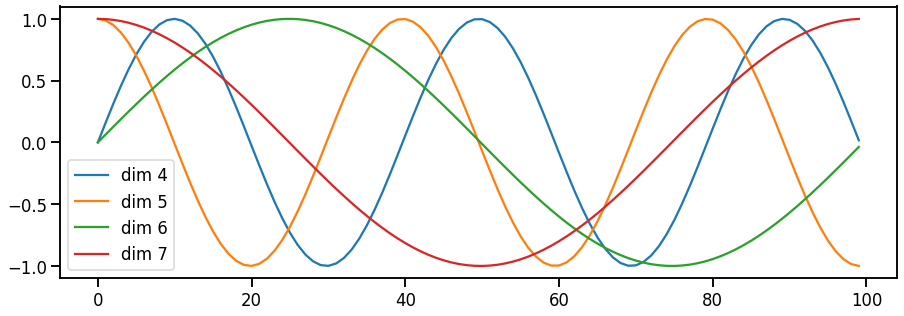

In [ ]:
plt.figure(figsize=(15, 5))
pe = PositionalEncoding(20, 0)
y = pe.forward(Variable(torch.zeros(1, 100, 20)))
plt.plot(np.arange(100), y[0, :, 4:8].data.numpy())
plt.legend(["dim %d"%p for p in [4,5,6,7]])
None

We also experimented with using learned positional embeddings [(cite)](https://arxiv.org/pdf/1705.03122.pdf) instead, and found that the two versions produced nearly identical results.  We chose the sinusoidal version because it may allow the model to extrapolate to sequence lengths longer than the ones encountered during training.

## Full Model

> Here we define a function from hyperparameters to a full model.

![alt text](https://lena-voita.github.io/resources/lectures/seq2seq/transformer/model-min.png)
Source: [Lena Voita's Lecture about Seq2Seq](https://lena-voita.github.io/nlp_course/seq2seq_and_attention.html)

In [ ]:
def make_model(src_vocab, tgt_vocab, N=6, d_model=512, d_ff=2048, h=8, dropout=0.1):
    "Helper: Construct a model from hyperparameters."
    c = copy.deepcopy  # use it for attn, ffn, and position in the model layers
    attn = MultiHeadedAttention(h, d_model)
    ff = PositionwiseFeedForward(d_model, d_ff, dropout)
    position = PositionalEncoding(d_model, dropout)
    # todo: insert correct arguments into the EncoderDecoder constructor.
    model = EncoderDecoder(
        Encoder(EncoderLayer(d_model, c(attn), c(ff), dropout), N),
        Decoder(DecoderLayer(d_model, c(attn), c(attn), c(ff), dropout), N),
        nn.Sequential(Embeddings(d_model, src_vocab), c(position)),
        nn.Sequential(Embeddings(d_model, tgt_vocab), c(position)),
        Generator(d_model, tgt_vocab)
    )

    # This was important from their code.
    # Initialize parameters with Glorot / fan_avg.
    for p in model.parameters():
        if p.dim() > 1:
            nn.init.xavier_uniform(p)
    return model

> **You have to complete the `make_model` function above. The cell below tests your implementation.**

In [ ]:
# Small example model.
tmp_model = make_model(10, 30, 2)
assert sum(p.numel() for p in tmp_model.parameters()) == 14750750

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.


True

In [ ]:
sum(p.numel() for p in tmp_model.encoder.parameters()) + sum(p.numel() for p in tmp_model.decoder.parameters()) + sum(p.numel() for p in tmp_model.tgt_embed.parameters()) + sum(p.numel() for p in tmp_model.src_embed.parameters()) + sum(p.numel() for p in tmp_model.generator.parameters())

14750750

In [ ]:
sum(tmp_model)

EncoderDecoder(
  (encoder): Encoder(
    (layers): ModuleList(
      (0): EncoderLayer(
        (self_attn): MultiHeadedAttention(
          (linears): ModuleList(
            (0): Linear(in_features=512, out_features=512, bias=True)
            (1): Linear(in_features=512, out_features=512, bias=True)
            (2): Linear(in_features=512, out_features=512, bias=True)
            (3): Linear(in_features=512, out_features=512, bias=True)
          )
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (feed_forward): PositionwiseFeedForward(
          (w_1): Linear(in_features=512, out_features=2048, bias=True)
          (w_2): Linear(in_features=2048, out_features=512, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (sublayer): ModuleList(
          (0): SublayerConnection(
            (norm): LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): SublayerConnection(
            (norm): LayerNorm()

# Training

This section describes the training regime for our models.

> We stop for a quick interlude to introduce some of the tools
needed to train a standard encoder decoder model. First we define a batch object that holds the src and target sentences for training, as well as constructing the masks.

## Batches and Masking

In [ ]:
class Batch:
    "Object for holding a batch of data with mask during training."
    def __init__(self, src, trg=None, pad=0):
        self.src = src
        self.src_mask = (src != pad).unsqueeze(-2)
        if trg is not None:
            self.trg = trg[:, :-1]
            self.trg_y = trg[:, 1:]
            self.trg_mask = \
                self.make_std_mask(self.trg, pad)
            self.ntokens = (self.trg_y != pad).data.sum()

    @staticmethod
    def make_std_mask(tgt, pad):
        "Create a mask to hide padding and future words."
        tgt_mask = (tgt != pad).unsqueeze(-2)
        tgt_mask = tgt_mask & Variable(
            subsequent_mask(tgt.size(-1)).type_as(tgt_mask.data))
        return tgt_mask

> Next we create a generic training and scoring function to keep track of loss. We pass in a generic loss compute function that also handles parameter updates.

## Training Loop

In [ ]:
def run_epoch(data_iter, model, loss_compute):
    "Standard Training and Logging Function"
    start = time.time()
    total_tokens = 0
    total_loss = 0
    tokens = 0
    for i, batch in enumerate(data_iter):
        out = model.forward(batch.src, batch.trg,
                            batch.src_mask, batch.trg_mask)
        loss = loss_compute(out, batch.trg_y, batch.ntokens)
        total_loss += loss
        total_tokens += batch.ntokens
        tokens += batch.ntokens
        if i % 50 == 1:
            elapsed = time.time() - start
            print("Epoch Step: %d Loss: %f Tokens per Sec: %f" %
                    (i, loss / batch.ntokens, tokens / elapsed))
            start = time.time()
            tokens = 0
    return total_loss / total_tokens

## Training Data and Batching

We trained on the standard WMT 2014 English-German dataset consisting of about 4.5 million sentence pairs.  Sentences were encoded using byte-pair encoding, which has a shared source-target vocabulary of about 37000 tokens. For English-French, we used the significantly larger WMT 2014 English-French dataset consisting of 36M sentences and split tokens into a 32000 word-piece vocabulary.


Sentence pairs were batched together by approximate sequence length.  Each training batch contained a set of sentence pairs containing approximately 25000 source tokens and 25000 target tokens.

> We will use torch text for batching. This is discussed in more detail below. Here we create batches in a torchtext function that ensures our batch size padded to the maximum batchsize does not surpass a threshold (25000 if we have 8 gpus).

In [ ]:
global max_src_in_batch, max_tgt_in_batch
def batch_size_fn(new, count, sofar):
    "Keep augmenting batch and calculate total number of tokens + padding."
    global max_src_in_batch, max_tgt_in_batch
    if count == 1:
        max_src_in_batch = 0
        max_tgt_in_batch = 0
    max_src_in_batch = max(max_src_in_batch,  len(new.src))
    max_tgt_in_batch = max(max_tgt_in_batch,  len(new.trg) + 2)
    src_elements = count * max_src_in_batch
    tgt_elements = count * max_tgt_in_batch
    return max(src_elements, tgt_elements)

## Hardware and Schedule
We trained our models on one machine with 8 NVIDIA P100 GPUs.  For our base models using the hyperparameters described throughout the paper, each training step took about 0.4 seconds.  We trained the base models for a total of 100,000 steps or 12 hours. For our big models, step time was 1.0 seconds.  The big models were trained for 300,000 steps (3.5 days).

## Optimizer

We used the Adam optimizer [(cite)](https://arxiv.org/abs/1412.6980) with $\beta_1=0.9$, $\beta_2=0.98$ and $\epsilon=10^{-9}$.  We varied the learning rate over the course of training, according to the formula:
$$
lrate = d_{\text{model}}^{-0.5} \cdot
  \min({step\_num}^{-0.5},
    {step\_num} \cdot {warmup\_steps}^{-1.5})
$$
This corresponds to increasing the learning rate linearly for the first $warmup\_steps$ training steps, and decreasing it thereafter proportionally to the inverse square root of the step number.  We used $warmup\_steps=4000$.

> Note: This part is very important. Need to train with this setup of the model.

In [ ]:

class NoamOpt:
    "Optim wrapper that implements rate."
    def __init__(self, model_size, factor, warmup, optimizer):
        self.optimizer = optimizer
        self._step = 0
        self.warmup = warmup
        self.factor = factor
        self.model_size = model_size
        self._rate = 0

    def step(self):
        "Update parameters and rate"
        self._step += 1
        rate = self.rate()
        for p in self.optimizer.param_groups:
            p['lr'] = rate
        self._rate = rate
        self.optimizer.step()

    def rate(self, step = None):
        "Implement `lrate` above"
        if step is None:
            step = self._step
        return self.factor * \
            (self.model_size ** (-0.5) *
            min(step ** (-0.5), step * self.warmup ** (-1.5)))

def get_std_opt(model):
    return NoamOpt(model.src_embed[0].d_model, 2, 4000,
            torch.optim.Adam(model.parameters(), lr=0, betas=(0.9, 0.98), eps=1e-9))


> Example of the curves of this model for different model sizes and for optimization hyperparameters.

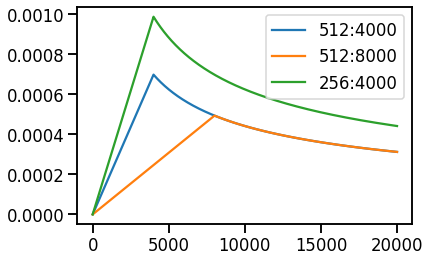

In [ ]:
# Three settings of the lrate hyperparameters.
opts = [NoamOpt(512, 1, 4000, None),
        NoamOpt(512, 1, 8000, None),
        NoamOpt(256, 1, 4000, None)]
plt.plot(np.arange(1, 20000), [[opt.rate(i) for opt in opts] for i in range(1, 20000)])
plt.legend(["512:4000", "512:8000", "256:4000"])
None

## Regularization

### Label Smoothing

During training, we employed label smoothing of value $\epsilon_{ls}=0.1$ [(cite)](https://arxiv.org/abs/1512.00567).  This hurts perplexity, as the model learns to be more unsure, but improves accuracy and BLEU score.

![](https://i2.wp.com/img-blog.csdnimg.cn/20200506164053747.png?x-oss-process=image/watermark,type_ZmFuZ3poZW5naGVpdGk,shadow_10,text_aHR0cHM6Ly9ibG9nLmNzZG4ubmV0L0d1b19QeXRob24=,size_16,color_FFFFFF,t_70)

> We implement label smoothing using the KL div loss. Instead of using a one-hot target distribution, we create a distribution that has `confidence` of the correct word and the rest of the `smoothing` mass distributed throughout the vocabulary.

In [ ]:
class LabelSmoothing(nn.Module):
    "Implement label smoothing."
    def __init__(self, size, padding_idx, smoothing=0.0):
        super(LabelSmoothing, self).__init__()
        self.criterion = nn.KLDivLoss(size_average=False)
        self.padding_idx = padding_idx
        self.confidence = 1.0 - smoothing
        self.smoothing = smoothing
        self.size = size
        self.true_dist = None

    def forward(self, x, target):
        assert x.size(1) == self.size
        true_dist = x.data.clone()
        true_dist.fill_(self.smoothing / (self.size - 2))
        true_dist.scatter_(1, target.data.unsqueeze(1), self.confidence)
        true_dist[:, self.padding_idx] = 0
        mask = torch.nonzero(target.data == self.padding_idx)
        if mask.dim() > 0:
            true_dist.index_fill_(0, mask.squeeze(), 0.0)
        self.true_dist = true_dist
        return self.criterion(x, Variable(true_dist, requires_grad=False))

> Here we can see an example of how the mass is distributed to the words based on confidence.

> Label smoothing actually starts to penalize the model if it gets very confident about a given choice.

# A First  Example

> We can begin by trying out a simple copy-task. Given a random set of input symbols from a small vocabulary, the goal is to generate back those same symbols.

## Synthetic Data

In [ ]:
def data_gen(V, batch, nbatches):
    "Generate random data for a src-tgt copy task."
    for i in range(nbatches):
        data = torch.from_numpy(np.random.randint(1, V, size=(batch, 10)))
        data[:, 0] = 1
        src = Variable(data, requires_grad=False)
        tgt = Variable(data, requires_grad=False)
        yield Batch(src, tgt, 0)

## Loss Computation

In [ ]:
class SimpleLossCompute:
    "A simple loss compute and train function."
    def __init__(self, generator, criterion, opt=None):
        self.generator = generator
        self.criterion = criterion
        self.opt = opt

    def __call__(self, x, y, norm):
        x = self.generator(x)
        loss = self.criterion(x.contiguous().view(-1, x.size(-1)),
                              y.contiguous().view(-1)) / norm
        loss.backward()
        if self.opt is not None:
            self.opt.step()
            self.opt.optimizer.zero_grad()
        return loss.item() * norm

## Greedy Decoding

In [ ]:
# Train the simple copy task.
V = 11
criterion = LabelSmoothing(size=V, padding_idx=0, smoothing=0.0)
model = make_model(V, V, N=2)
model_opt = NoamOpt(model.src_embed[0].d_model, 1, 400,
        torch.optim.Adam(model.parameters(), lr=0, betas=(0.9, 0.98), eps=1e-9))

for epoch in range(5):
    model.train()
    run_epoch(data_gen(V, 20, 30), model,
              SimpleLossCompute(model.generator, criterion, model_opt))
    model.eval()
    print(run_epoch(data_gen(V, 20, 5), model,
                    SimpleLossCompute(model.generator, criterion, None)))

/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.


Epoch Step: 1 Loss: 3.186823 Tokens per Sec: 348.367584
Epoch Step: 1 Loss: 1.756198 Tokens per Sec: 553.351440
tensor(1.8042)
Epoch Step: 1 Loss: 1.955566 Tokens per Sec: 432.972717
Epoch Step: 1 Loss: 1.543282 Tokens per Sec: 558.018677
tensor(1.4911)
Epoch Step: 1 Loss: 1.904338 Tokens per Sec: 432.413757
Epoch Step: 1 Loss: 1.149316 Tokens per Sec: 559.920532
tensor(1.1624)
Epoch Step: 1 Loss: 1.422492 Tokens per Sec: 314.996735
Epoch Step: 1 Loss: 0.666511 Tokens per Sec: 540.842285
tensor(0.6943)
Epoch Step: 1 Loss: 0.895048 Tokens per Sec: 421.814117
Epoch Step: 1 Loss: 0.596292 Tokens per Sec: 550.257874
tensor(0.6447)


> This code predicts a translation using greedy decoding for simplicity.

In [ ]:
def greedy_decode(model, src, src_mask, max_len, start_symbol):
    memory = model.encode(src.to(device), src_mask.to(device))
    ys = torch.ones(1, 1).fill_(start_symbol).type_as(src.data)
    for i in range(max_len-1):
        out = model.decode(memory, src_mask.to(device),
                           Variable(ys).to(device),
                           Variable(subsequent_mask(ys.size(1))
                                    .type_as(src.data).to(device)))
        prob = model.generator(out[:, -1])
        _, next_word = torch.max(prob, dim = 1)
        next_word = next_word.data[0]
        ys = torch.cat([ys,
                        torch.ones(1, 1).type_as(src.data).fill_(next_word)], dim=1)
    return ys

model.eval()
src = Variable(torch.LongTensor([[1,2,3,4,5,6,7,8,9,10]]) )
src_mask = Variable(torch.ones(1, 1, 10) )
print(greedy_decode(model.to(device), src, src_mask, max_len=10, start_symbol=1))

tensor([[1, 2, 3, 5, 4, 6, 7, 8, 8, 9]])


# Memory Optimization

In [ ]:
def loss_backprop(generator, criterion, out, targets, normalize):
    """
    Memory optmization. Compute each timestep separately and sum grads.
    """
    assert out.size(1) == targets.size(1)
    total = 0.0
    out_grad = []
    for i in range(out.size(1)):
        out_column = Variable(out[:, i].data, requires_grad=True)
        gen = generator(out_column)
        loss = criterion(gen, targets[:, i]) / normalize
        total += loss.item() #.data[0]
        loss.backward()
        out_grad.append(out_column.grad.data.clone())
    out_grad = torch.stack(out_grad, dim=1)
    out.backward(gradient=out_grad)
    return total

In [ ]:
def make_std_mask(src, tgt, pad):
    src_mask = (src != pad).unsqueeze(-2)
    tgt_mask = (tgt != pad).unsqueeze(-2)
    tgt_mask = tgt_mask & Variable(subsequent_mask(tgt.size(-1)).type_as(tgt_mask.data))
    return src_mask, tgt_mask

In [ ]:
def train_epoch(train_iter, model, criterion, opt, transpose=False):
    model.train()
    for i, batch in enumerate(train_iter):
        src, trg, src_mask, trg_mask = \
                batch.src.to(device), batch.trg.to(device), batch.src_mask.to(device), batch.trg_mask.to(device)
        out = model.forward(src, trg[:, :-1], src_mask, trg_mask[:, :-1, :-1])
        loss = loss_backprop(model.generator, criterion, out, trg[:, 1:], batch.ntokens)

        model_opt.step()
        model_opt.optimizer.zero_grad()
        if i % 10 == 1:
            print(i, loss, model_opt._rate)

In [ ]:
def valid_epoch(valid_iter, model, criterion, transpose=False):
    model.eval()
    total = 0
    for batch in valid_iter:
        src, trg, src_mask, trg_mask = \
            batch.src.to(device), batch.trg.to(device), batch.src_mask.to(device), batch.trg_mask.to(device)
        out = model.forward(src, trg[:, :-1], src_mask, trg_mask[:, :-1, :-1])
        loss = loss_backprop(model.generator, criterion, out, trg[:, 1:], batch.ntokens)

In [ ]:
class Batch:
    def __init__(self, src, trg, src_mask, trg_mask, ntokens):
        self.src = src
        self.trg = trg
        self.src_mask = src_mask
        self.trg_mask = trg_mask
        self.ntokens = ntokens

def data_gen(V, batch, nbatches):
    for i in range(nbatches):
        data = torch.from_numpy(np.random.randint(1, V, size=(batch, 10)))
        src = Variable(data, requires_grad=False)
        tgt = Variable(data, requires_grad=False)
        src_mask, tgt_mask = make_std_mask(src, tgt, 0)
        yield Batch(src, tgt, src_mask, tgt_mask, (tgt[1:] != 0).data.sum())

In [ ]:
V = 11
criterion = LabelSmoothing(size=V, padding_idx=0, smoothing=0.0)
model = make_model(V, V, N=2).to(device)
model_opt = get_std_opt(model)
for epoch in range(2):
    train_epoch(data_gen(V, 10, 10), model, criterion, model_opt)

/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.


1 3.0303337424993515 6.987712429686844e-07
1 2.891311153769493 4.192627457812107e-06


# A Real World Example

> Now we consider a real-world example using the Tatoeba Russian-English parallel data. This task is much smaller than the WMT task considered in the paper, but it illustrates the whole system.

## Data Loading
> We will load the dataset using torchtext and spacy for tokenization.

In [ ]:
!pip install datasets torchtext
!pip install --upgrade spacy
!python -m spacy download en_core_web_sm
!python -m spacy download ru_core_news_sm

In [ ]:
from tqdm.auto import tqdm, trange

In [ ]:
import spacy
spacy_ru = spacy.load('ru_core_news_sm')
spacy_en = spacy.load('en_core_web_sm')

def tokenize_ru(text):
    return [tok.text for tok in spacy_ru.tokenizer(text)]

def tokenize_en(text):
    return [tok.text for tok in spacy_en.tokenizer(text)]

BOS_WORD = '<s>'
EOS_WORD = '</s>'
BLANK_WORD = "<blank>"
UNK_WORD = '<unk>'
#SRC = data.Field(tokenize=tokenize_de, pad_token=BLANK_WORD)
#TGT = data.Field(tokenize=tokenize_en, init_token = BOS_WORD, eos_token = EOS_WORD, pad_token=BLANK_WORD)

MAX_LEN = 100

Load data from https://huggingface.co/datasets/tatoeba

In [ ]:
from datasets import load_dataset

In [ ]:
# data = load_dataset('opus_books', 'en-ru')
data = load_dataset('tatoeba', lang1='en', lang2='ru')

Using custom data configuration en-ru-lang1=en,lang2=ru


Generating train split: 0 examples [00:00, ? examples/s]

Dataset tatoeba downloaded and prepared to /root/.cache/huggingface/datasets/tatoeba/en-ru-lang1=en,lang2=ru/0.0.0/b3ea9c6bb2af47699c5fc0a155643f5a0da287c7095ea14824ee0a8afd74daf6. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
data

DatasetDict({
    train: Dataset({
        features: ['id', 'translation'],
        num_rows: 523656
    })
})

In [ ]:
data['train'][0]

{'id': '0',
 'translation': {'en': "For once in my life I'm doing a good deed... And it is useless.",
  'ru': 'Один раз в жизни я делаю хорошее дело... И оно бесполезно.'}}

In [ ]:
data2 = data['train'].filter(lambda x: max(len(x['translation']['ru']), len(x['translation']['en'])) <= MAX_LEN).train_test_split(test_size=1000, shuffle=True, seed=2)
data2

  0%|          | 0/524 [00:00<?, ?ba/s]

DatasetDict({
    train: Dataset({
        features: ['id', 'translation'],
        num_rows: 519480
    })
    test: Dataset({
        features: ['id', 'translation'],
        num_rows: 1000
    })
})

In [ ]:
train_src = [d['ru'] for d in data2['train']['translation']]
train_trg = [d['en'] for d in data2['train']['translation']]

val_src = [d['ru'] for d in data2['test']['translation']]
val_trg = [d['en'] for d in data2['test']['translation']]

In [ ]:
from collections import Counter

def build_vocab(texts, tokenize, min_freq=3, init_token=BOS_WORD, eos_token=EOS_WORD, pad_token=BLANK_WORD, unk_token=UNK_WORD):
    cnt = Counter()
    for text in tqdm(texts):
        cnt.update(tokenize(text))
    vocab = [pad_token, init_token, eos_token, unk_token]
    for w, c in cnt.most_common():
        if c < min_freq:
            break
        vocab.append(w)
    return vocab

In [ ]:
src_vocab = build_vocab(train_src, tokenize_ru)
tgt_vocab = build_vocab(train_trg, tokenize_en)
print(len(src_vocab))
print(len(tgt_vocab))
print(src_vocab[:10])

  0%|          | 0/519480 [00:00<?, ?it/s]

  0%|          | 0/519480 [00:00<?, ?it/s]

35289
14772
['<blank>', '<s>', '</s>', '<unk>', '.', ',', 'не', 'Я', '?', 'Том']


In [ ]:
inv_voc_src = {w:i for i, w in enumerate(src_vocab)}
inv_voc_tgt = {w:i for i, w in enumerate(tgt_vocab)}

In [ ]:
def tokenize(text, tokenize_fn, inv_vocab, bos_id=1, eos_id=2, unk_id=3):
    result = [bos_id]
    for word in tokenize_fn(text):
        if word in inv_vocab:
            result.append(inv_vocab[word])
        else:
            result.append(unk_id)
    result.append(eos_id)
    return result

In [ ]:
train_src_tokenized = [tokenize(t, tokenize_ru, inv_voc_src) for t in tqdm(train_src)]
train_tgt_tokenized = [tokenize(t, tokenize_en, inv_voc_tgt) for t in tqdm(train_trg)]

val_src_tokenized = [tokenize(t, tokenize_ru, inv_voc_src) for t in tqdm(val_src)]
val_tgt_tokenized = [tokenize(t, tokenize_en, inv_voc_tgt) for t in tqdm(val_trg)]

  0%|          | 0/519480 [00:00<?, ?it/s]

  0%|          | 0/519480 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

In [ ]:
train_src_tokenized[0]

[1, 2694, 7226, 28600, 7007, 4, 2]

In [ ]:
def padding(sequences, pad_id=0):
    max_len = max(len(s) for s in sequences)
    return [s + [pad_id] * (max_len-len(s)) for s in sequences]

In [ ]:
print(padding(train_src_tokenized[0:3]))

[[1, 2694, 7226, 28600, 7007, 4, 2, 0], [1, 9, 3975, 18, 1214, 4, 2, 0], [1, 31, 21343, 25, 2062, 169, 4, 2]]


In [ ]:
import random

def data_iterator(srcs, tgts, batch_size=128, shuffle=True):
    if shuffle:
        pairs = list(zip(srcs, tgts))
        random.shuffle(pairs)
        srcs, tgts = [list(t) for t in zip(*pairs)]

    for i in trange(0, len(srcs), batch_size):
        x = torch.tensor(padding(srcs[i: i + batch_size]))
        y = torch.tensor(padding(tgts[i: i + batch_size]))
        src = Variable(x, requires_grad=False)
        tgt = Variable(y, requires_grad=False)
        src_mask, tgt_mask = make_std_mask(src, tgt, 0)
        yield Batch(src, tgt, src_mask, tgt_mask, (tgt[1:] != 0).data.sum())

## Training

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
# Create the model an load it onto our GPU.
pad_idx = tgt_vocab.index("<blank>")
model = make_model(len(src_vocab), len(tgt_vocab), N=6)
model_opt = get_std_opt(model)
model.to(device)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.


EncoderDecoder(
  (encoder): Encoder(
    (layers): ModuleList(
      (0): EncoderLayer(
        (self_attn): MultiHeadedAttention(
          (linears): ModuleList(
            (0): Linear(in_features=512, out_features=512, bias=True)
            (1): Linear(in_features=512, out_features=512, bias=True)
            (2): Linear(in_features=512, out_features=512, bias=True)
            (3): Linear(in_features=512, out_features=512, bias=True)
          )
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (feed_forward): PositionwiseFeedForward(
          (w_1): Linear(in_features=512, out_features=2048, bias=True)
          (w_2): Linear(in_features=2048, out_features=512, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (sublayer): ModuleList(
          (0): SublayerConnection(
            (norm): LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): SublayerConnection(
            (norm): LayerNorm()

In [ ]:
def count_parameters(model: nn.Module):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 77,349,812 trainable parameters


In [ ]:
BATCH_SIZE = 128

In [ ]:
criterion = LabelSmoothing(size=len(tgt_vocab), padding_idx=pad_idx, smoothing=0.1)
criterion.cuda()

/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


LabelSmoothing(
  (criterion): KLDivLoss()
)

In [ ]:
for epoch in trange(3):
    train_epoch(data_iterator(train_src_tokenized, train_tgt_tokenized, batch_size=BATCH_SIZE), model, criterion, model_opt)
    valid_epoch(data_iterator(val_src_tokenized, val_tgt_tokenized, batch_size=BATCH_SIZE), model, criterion)

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/4059 [00:00<?, ?it/s]

1 7.545947188511491 6.987712429686844e-07
11 7.38592858472839 4.192627457812107e-06
21 7.110072645824403 7.686483672655528e-06
31 6.942665494978428 1.118033988749895e-05
41 6.79478248860687 1.4674196102342371e-05
51 6.63777367817238 1.8168052317185794e-05
61 6.47614682209678 2.1661908532029216e-05
71 6.330896493047476 2.515576474687264e-05
81 6.158351567341015 2.8649620961716057e-05
91 5.989467842038721 3.214347717655948e-05
101 5.861081714509055 3.56373333914029e-05
111 5.5564495348371565 3.913118960624633e-05
121 5.323668197845109 4.262504582108975e-05
131 5.004340100684203 4.611890203593317e-05
141 4.858897513593547 4.961275825077659e-05
151 4.730439270089846 5.310661446562001e-05
161 4.471505916269962 5.660047068046343e-05
171 4.3179471212788485 6.0094326895306855e-05
181 4.262772616464645 6.358818311015028e-05
191 4.072849749965826 6.70820393249937e-05
201 3.9635919919237494 7.057589553983712e-05
211 3.8699555459897965 7.406975175468054e-05
221 3.903830169918365 7.756360796952397e

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/4059 [00:00<?, ?it/s]

1 1.4509872806484054 0.001387006576956668
11 1.3984406016534194 0.001385302008809946
21 1.1895379672350828 0.00138360370976663
31 1.1411875625253742 0.0013819116414929245
41 1.4605732241270744 0.0013802257659823946
51 1.294289976908658 0.0013785460455523785
61 1.2917329313640948 0.0013768724428404521
71 1.4319793295580894 0.0013752049208009367
81 1.320942702186585 0.0013735434427014556
91 1.19387065441515 0.0013718879721195366
101 1.2055542081070598 0.0013702384729392557
111 1.3999983044195687 0.001368594909347931
121 1.3622560799994972 0.001366957245832855
131 1.4880018442199798 0.001365325447178072
141 1.4559757599236036 0.0013636994784611983
151 1.4768804206614732 0.0013620793050502823
161 1.4208921649424155 0.0013604648926007067
171 1.4471051927394 0.0013588562070521307
181 1.355191075548646 0.0013572532146254718
191 1.3831316912965121 0.0013556558818199262
201 1.4747461173392367 0.0013540641754100297
211 1.3544409958158212 0.0013524780624427526
221 1.211709768829678 0.001350897510

KeyboardInterrupt: ignored

Example of usage

In [ ]:
model.eval()
sent = "Добрый день, как у вас дела ?".split()
src = Variable(torch.LongTensor([tokenize("Добрый день, как у вас дела?", tokenize_ru, inv_voc_src)]))
src_mask = (src != src_vocab.index("<blank>")).unsqueeze(-2)
print(src)
print(src_mask)

tensor([[   1, 9937,  127,    5,   39,   38,   65,  742,    8,    2]])
tensor([[[True, True, True, True, True, True, True, True, True, True]]])


In [ ]:
out = greedy_decode(model, src.to(device), src_mask.to(device), max_len=60, start_symbol=tgt_vocab.index("<s>"))
print(out)

tensor([[   1,   31,    8, 1441,  128,  204,  157,    9,    2,    9,    2,    9,
            2,    9,    2,    9,    2,    9,    2,    9,    2,    9,    2,    9,
            2,    9,    2,    9,    2,    9,    2,    9,    2,    9,    2,    9,
            2,    9,    2,    9,    2,    9,    2,    9,    2,    9,    2,    9,
            2,    9,    2,    9,    2,    9,    2,    9,    2,    9,    2,    9]],
       device='cuda:0')


In [ ]:
print("Translation:", end="\t")
trans = "<s> "
for i in range(1, out.size(1)):
    sym = tgt_vocab[out[0, i]]
    if sym == "</s>": break
    trans += sym + " "
print(trans)

Translation:	<s> Do you realize how new day ? 


# Results

On the WMT 2014 English-to-German translation task, the big transformer model (Transformer (big)
in Table 2) outperforms the best previously reported models (including ensembles) by more than 2.0
BLEU, establishing a new state-of-the-art BLEU score of 28.4. The configuration of this model is
listed in the bottom line of Table 3. Training took 3.5 days on 8 P100 GPUs. Even our base model
surpasses all previously published models and ensembles, at a fraction of the training cost of any of
the competitive models.

On the WMT 2014 English-to-French translation task, our big model achieves a BLEU score of 41.0,
outperforming all of the previously published single models, at less than 1/4 the training cost of the
previous state-of-the-art model. The Transformer (big) model trained for English-to-French used
dropout rate Pdrop = 0.1, instead of 0.3.



![alt text](https://nlp.seas.harvard.edu/images/the-annotated-transformer_113_0.png)

> The code we have written here is a version of the base model. There are fully trained version of this system available here  [(Example Models)](http://opennmt.net/Models-py/).
>
> With the addtional extensions in the last section, the OpenNMT-py replication gets to 26.9 on EN-DE WMT. Here I have loaded in those parameters to our reimplemenation.

In [ ]:
!wget https://s3.amazonaws.com/opennmt-models/en-de-model.pt

--2022-06-14 13:18:34--  https://s3.amazonaws.com/opennmt-models/en-de-model.pt
Resolving s3.amazonaws.com (s3.amazonaws.com)... 54.231.195.72
Connecting to s3.amazonaws.com (s3.amazonaws.com)|54.231.195.72|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 393031182 (375M) [application/x-www-form-urlencoded]
Saving to: ‘en-de-model.pt’

en-de-model.pt      100%[===================>] 374.82M  62.5MB/s    in 5.9s    

2022-06-14 13:18:40 (63.0 MB/s) - ‘en-de-model.pt’ saved [393031182/393031182]



In [ ]:
model, SRC, TGT = torch.load("en-de-model.pt")

/usr/local/lib/python3.7/dist-packages/torch/serialization.py:786: SourceChangeWarning: source code of class 'torch.nn.modules.container.ModuleList' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/usr/local/lib/python3.7/dist-packages/torch/serialization.py:786: SourceChangeWarning: source code of class 'torch.nn.modules.linear.Linear' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/usr/local/lib/python3.7/dist-packages/torch/serialization.py:786: SourceChangeWarning: source code of class 'torch.nn.modules.dropout.Dropout' has changed. you can retrieve the original source code by accessing the object's source attribute or se

In [ ]:
model.eval()
sent = "▁The ▁log ▁file ▁can ▁be ▁sent ▁secret ly ▁with ▁email ▁or ▁FTP ▁to ▁a ▁specified ▁receiver".split()
src = torch.LongTensor([[SRC.stoi[w] for w in sent]])
src = Variable(src)
src_mask = (src != SRC.stoi["<blank>"]).unsqueeze(-2)
out = greedy_decode(model.to(device), src.to(device), src_mask.to(device),
                    max_len=60, start_symbol=TGT.stoi["<s>"])
print("Translation:", end="\t")
trans = "<s> "
for i in range(1, out.size(1)):
    sym = TGT.itos[out[0, i]]
    if sym == "</s>": break
    trans += sym + " "
print(trans)

Translation:	<s> ▁Die ▁Protokoll datei ▁kann ▁ heimlich ▁per ▁E - Mail ▁oder ▁FTP ▁an ▁einen ▁bestimmte n ▁Empfänger ▁gesendet ▁werden . 


## Attention Visualization

> Even with a greedy decoder the translation looks pretty good. We can further visualize it to see what is happening at each layer of the attention

Encoder Layer 2


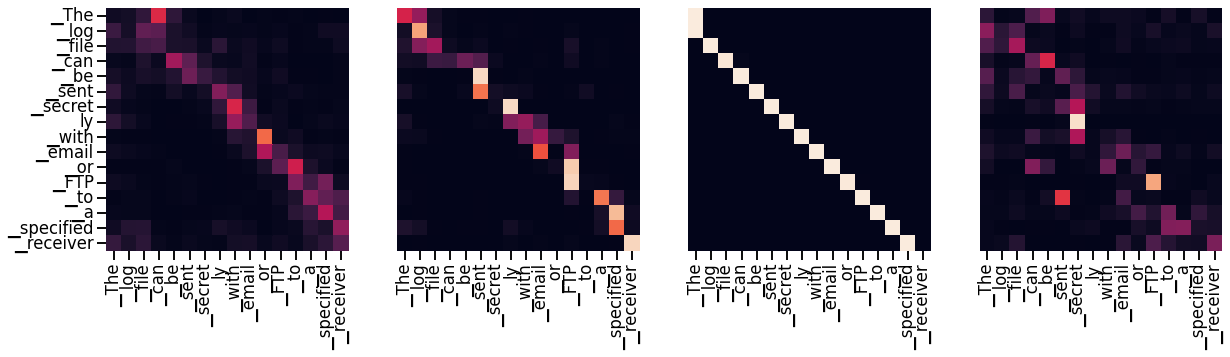

Encoder Layer 4


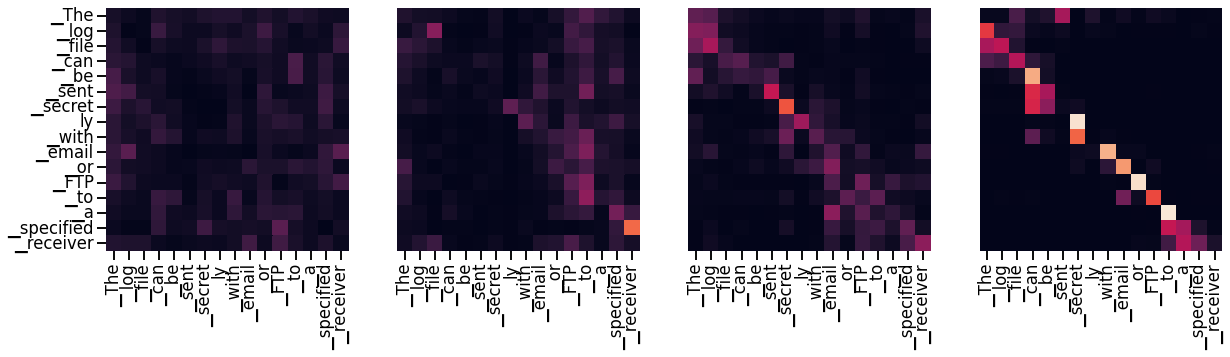

Encoder Layer 6


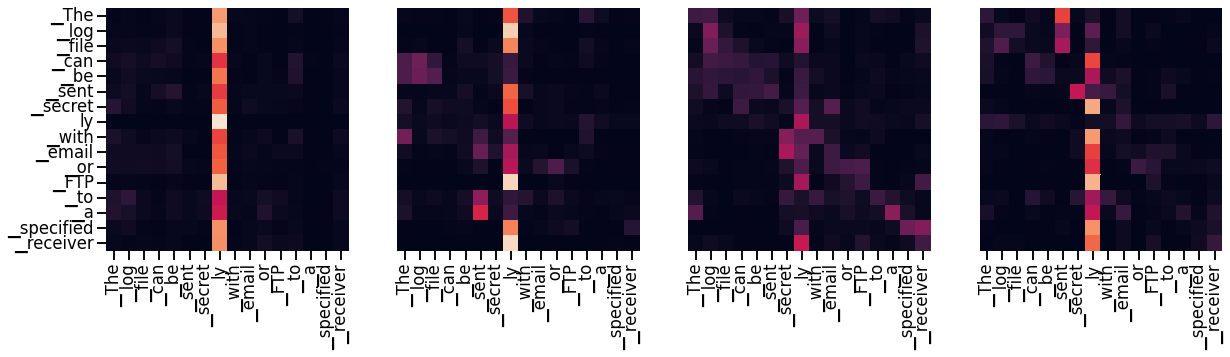

Decoder Self Layer 2


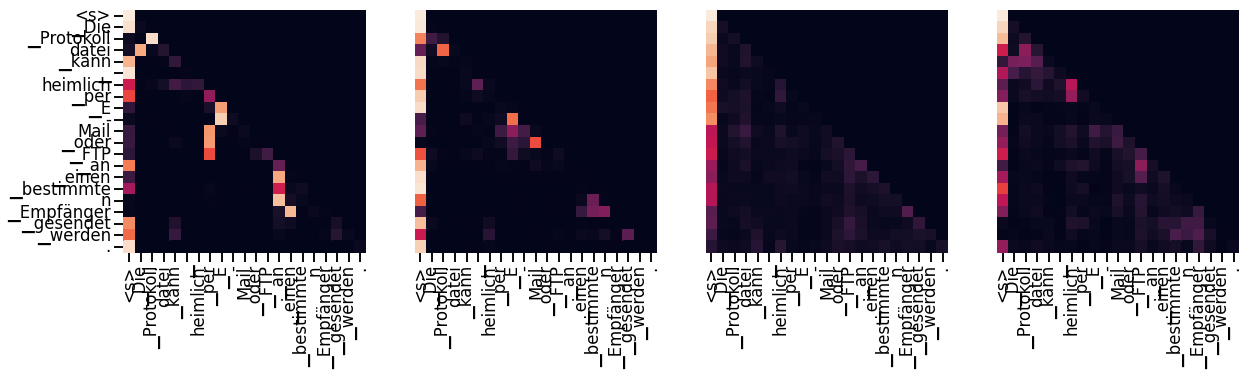

Decoder Src Layer 2


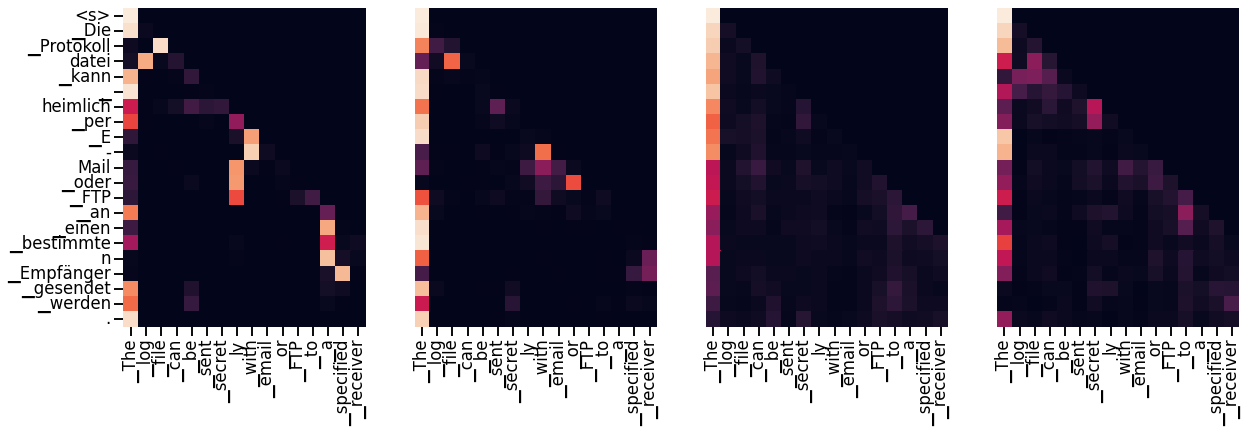

Decoder Self Layer 4


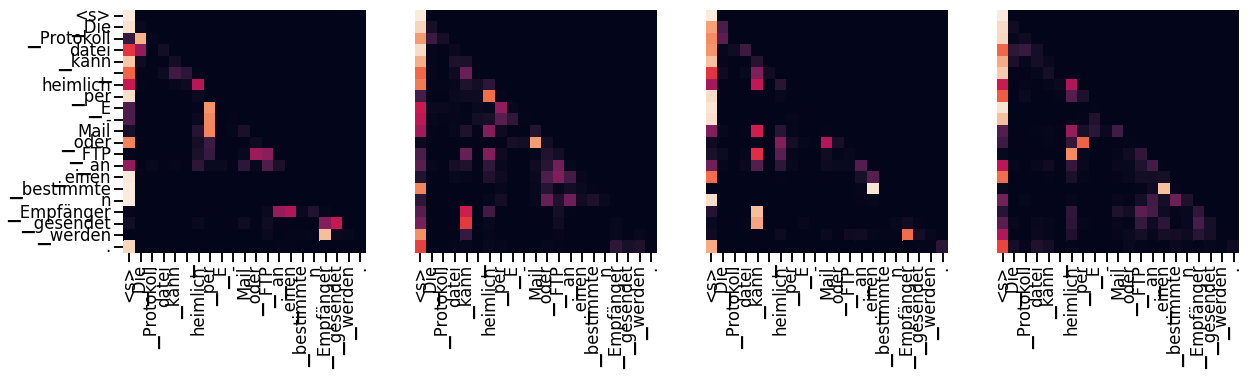

Decoder Src Layer 4


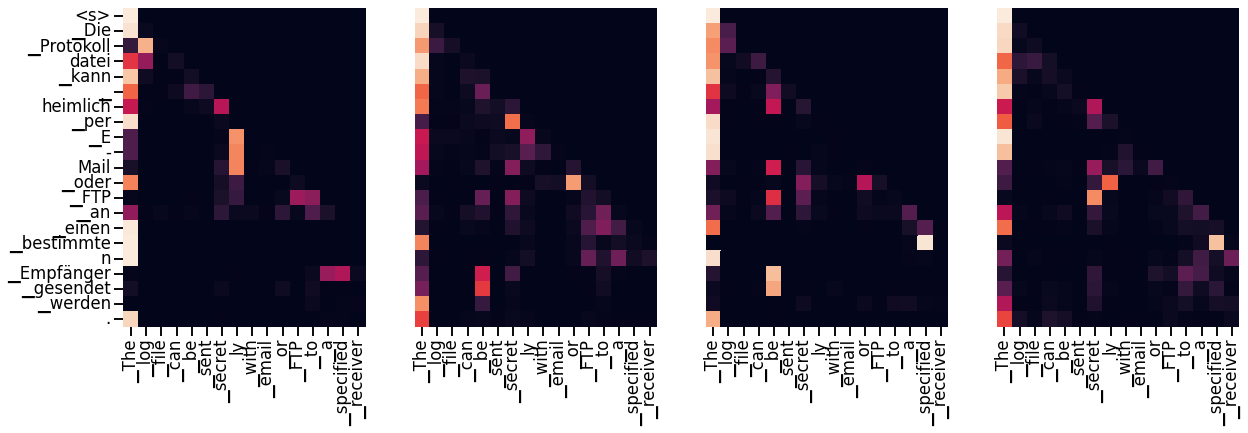

Decoder Self Layer 6


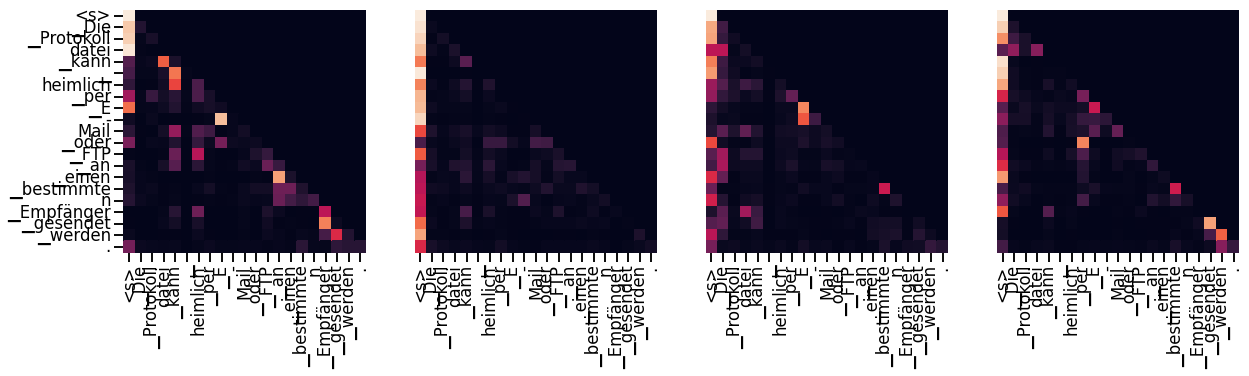

Decoder Src Layer 6


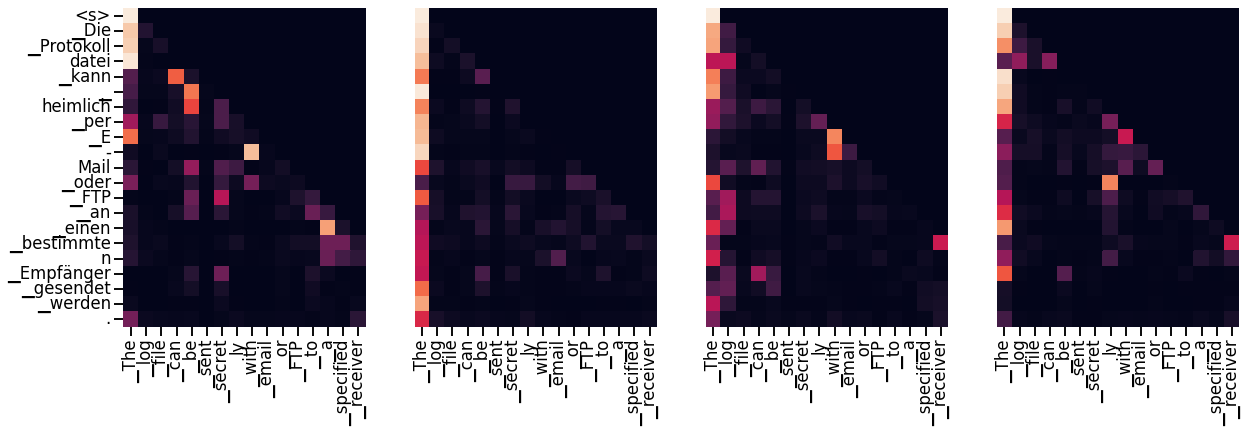

In [ ]:
tgt_sent = trans.split()
def draw(data, x, y, ax):
    seaborn.heatmap(data,
                    xticklabels=x, square=True, yticklabels=y, vmin=0.0, vmax=1.0,
                    cbar=False, ax=ax)

for layer in range(1, 6, 2):
    fig, axs = plt.subplots(1,4, figsize=(20, 10))
    print("Encoder Layer", layer+1)
    for h in range(4):
        draw(model.encoder.layers[layer].self_attn.attn[0, h].data.cpu(),
            sent, sent if h ==0 else [], ax=axs[h])
    plt.show()

for layer in range(1, 6, 2):
    fig, axs = plt.subplots(1,4, figsize=(20, 10))
    print("Decoder Self Layer", layer+1)
    for h in range(4):
        draw(model.decoder.layers[layer].self_attn.attn[0, h].data[:len(tgt_sent), :len(tgt_sent)].cpu(),
            tgt_sent, tgt_sent if h ==0 else [], ax=axs[h])
    plt.show()
    print("Decoder Src Layer", layer+1)
    fig, axs = plt.subplots(1,4, figsize=(20, 10))
    for h in range(4):
        draw(model.decoder.layers[layer].self_attn.attn[0, h].data[:len(tgt_sent), :len(sent)].cpu(),
            sent, tgt_sent if h ==0 else [], ax=axs[h])
    plt.show()


# Conclusion

> Hopefully this code is useful for future research. Please reach out if you have any issues. If you find this code helpful, also check out our other OpenNMT tools.

```
@inproceedings{opennmt,
  author    = {Guillaume Klein and
               Yoon Kim and
               Yuntian Deng and
               Jean Senellart and
               Alexander M. Rush},
  title     = {OpenNMT: Open-Source Toolkit for Neural Machine Translation},
  booktitle = {Proc. ACL},
  year      = {2017},
  url       = {https://doi.org/10.18653/v1/P17-4012},
  doi       = {10.18653/v1/P17-4012}
}
```